In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import io_utils

from matplotlib import pyplot as plt
from IPython import display

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
from configuration import *
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_SIZE 408
TRAIN_SIZE 347
TEST_SIZE 61


In [4]:
from dataset_utils import create_image_loader

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test"))
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

f2b_train_dataset = train_dataset.map(create_image_loader(2, 0, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
f2b_test_dataset = test_dataset.map(create_image_loader(2, 0, TEST_SIZES, "test"))
f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)

f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test"))
f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

Last 500 steps took: 75.07s
Estimated time to finish: 0.00min



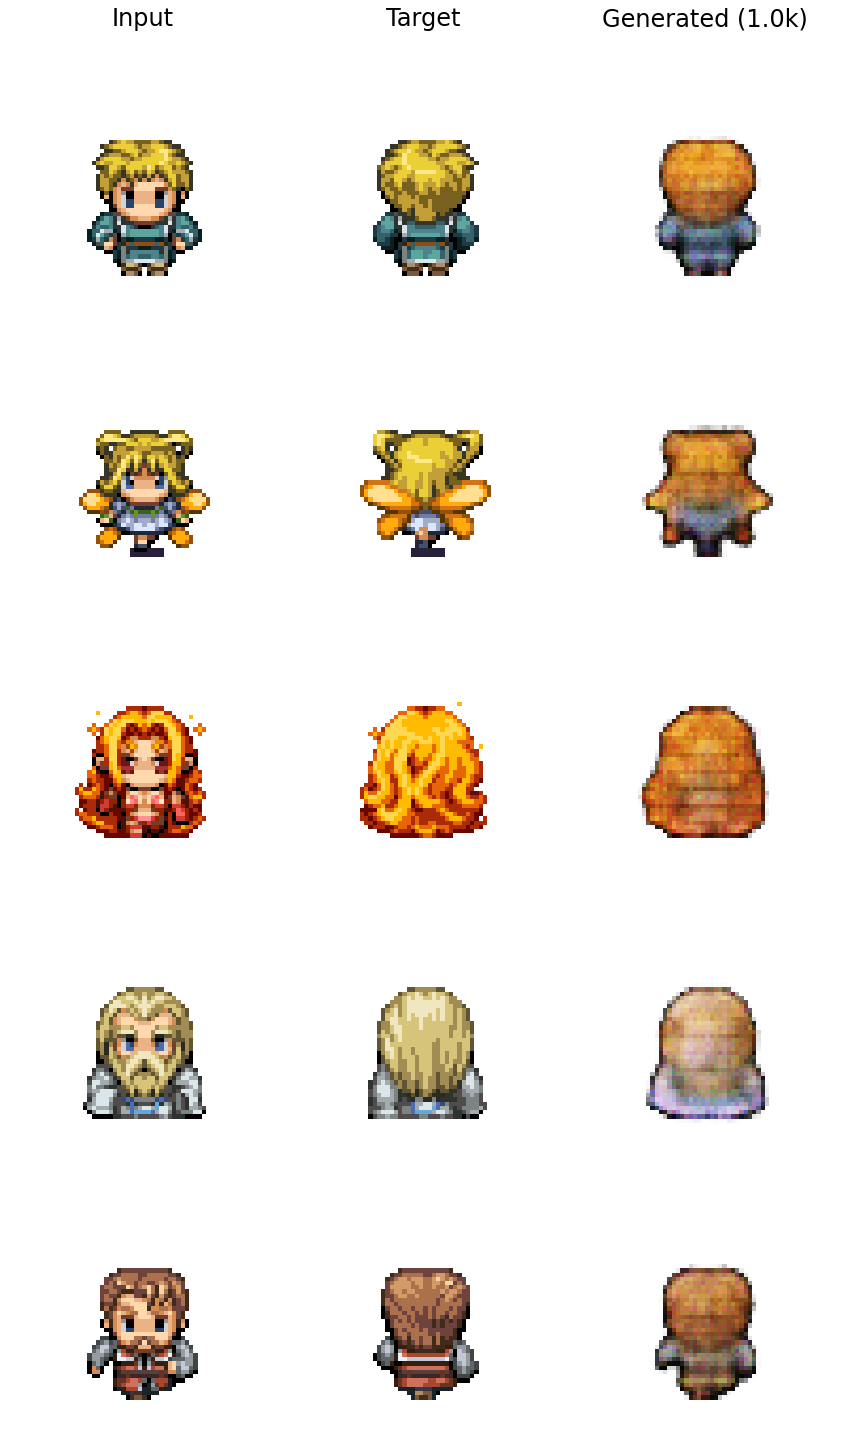

Calculating Fréchet Inception Distance at 1.0k with 61 test examples... FID: 17.20577
Step: 1.0k


In [5]:
Pix2PixModel = None
from pix2pix_model import Pix2PixModel, Pix2PixWassersteinModel, Pix2PixFFTModel


# f2r = Pix2PixFFTModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-fftsquare1000", LAMBDA_FFT=1000)
model = Pix2PixModel(f2b_train_dataset, f2b_test_dataset, "front2back", "pix2pix-playground")
# f2r = Pix2PixWassersteinModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-wgan")
STEPS = 1000
print("Starting training...")
model.fit(STEPS, 500)#, callbacks=["fid", "show_patches"])


In [6]:
# f2r.load_generator()
# model.generate_images_from_dataset()

In [7]:
# model.save_generator()
# model.save_discriminator()

In [8]:
# print("Showing discriminator output from TRAIn set...")
# model.generate_discriminated_images("train")
# print("Showing discriminator output from TEST set...")
# model.generate_discriminated_images("test")